# Логистическая регрессия: от теории к практике

В этом notebook мы:
1. Реализуем логистическую регрессию с нуля
2. Сравним с библиотечной реализацией sklearn
3. Разберем все метрики классификации
4. Научимся их правильно интерпретировать

---

## Теоретическая часть

### Сигмоида (Logistic Function)

Логистическая регрессия использует **сигмоиду** для преобразования линейной комбинации признаков в вероятность:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

где $z = w^T x + b$ - линейная комбинация весов и признаков.

### Функция потерь

**Binary Cross-Entropy (Log Loss)**:

$$\text{BCE} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right]$$

### Градиентный спуск

Обновление весов:

$$w := w - \alpha \cdot \frac{\partial \text{BCE}}{\partial w}$$

где $\alpha$ - learning rate (скорость обучения).

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

print('Библиотеки загружены')

Библиотеки загружены


---
## 1️⃣ Создание и подготовка данных

Создадим синтетический датасет для **бинарной классификации**:
- 1000 примеров
- 2 признака (для простоты визуализации)
- Сбалансированные классы

In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.1,
    random_state=42
)

print(f'Размер датасета: {X.shape}')
print('Распределение классов:')
print(f'  Класс 0: {np.sum(y == 0)} примеров')
print(f'  Класс 1: {np.sum(y == 1)} примеров')
print('\nПервые 5 примеров:')
print(X[:5])

Размер датасета: (1000, 2)
Распределение классов:
  Класс 0: 502 примеров
  Класс 1: 498 примеров

Первые 5 примеров:
[[ 0.4585091  -1.00438829]
 [ 0.36855907 -1.35598715]
 [ 1.28008457  0.98453788]
 [ 0.62008386 -1.03681815]
 [ 0.78414233 -0.88199821]]


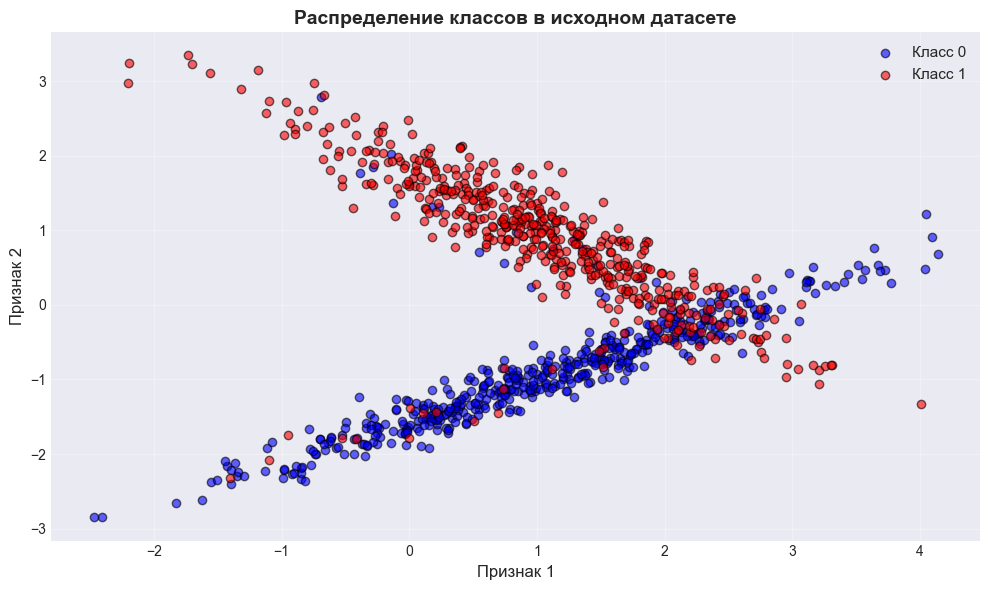

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], c='blue', label='Класс 0', alpha=0.6, edgecolors='k')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='red', label='Класс 1', alpha=0.6, edgecolors='k')
plt.xlabel('Признак 1', fontsize=12)
plt.ylabel('Признак 2', fontsize=12)
plt.title('Распределение классов в исходном датасете', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Разделение на train/test и стандартизация

**Зачем нужна стандартизация?**
- Ускоряет сходимость градиентного спуска
- Все признаки имеют одинаковый масштаб
- Формула: $x_{\text{scaled}} = \frac{x - \mu}{\sigma}$

In [4]:
# Разделение на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train set: {X_train_scaled.shape}')
print(f'Test set: {X_test_scaled.shape}')
print('\nСтатистики после стандартизации (train):')
print(f'  Mean: {X_train_scaled.mean(axis=0)}')
print(f'  Std: {X_train_scaled.std(axis=0)}')

Train set: (800, 2)
Test set: (200, 2)

Статистики после стандартизации (train):
  Mean: [-1.58623115e-15  9.71445147e-18]
  Std: [1. 1.]


---
## 2️⃣ Реализация логистической регрессии с нуля

Создадим класс, который реализует:
1. **Сигмоиду** - функцию активации
2. **Binary Cross-Entropy** - функцию потерь
3. **Градиентный спуск** - метод оптимизации

In [19]:
class LogisticRegressionScratch:
    """
    Логистическая регрессия с нуля
    
    Parameters:
    -----------
    learning_rate : float
        Скорость обучения (шаг градиентного спуска)
    n_iterations : int
        Количество итераций обучения
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.losses = []
    
    def sigmoid(self, z):
        """
        Сигмоида: σ(z) = 1 / (1 + e^(-z))
        Clip для numerical stability
        """
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def binary_cross_entropy(self, y_true, y_pred):
        """
        Binary Cross-Entropy Loss
        BCE = -1/n * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]
        """
        epsilon = 1e-15  # для numerical stability
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def fit(self, X, y, verbose=True):
        """
        Обучение модели с помощью градиентного спуска
        """
        n_samples, n_features = X.shape
        
        # Инициализация весов нулями
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Градиентный спуск
        for i in range(self.n_iterations):
            # Прямой проход (forward pass)
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            
            # Вычисление градиентов
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Обновление параметров (backward pass)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            # Сохранение loss для визуализации
            if i % 50 == 0:
                loss = self.binary_cross_entropy(y, y_predicted)
                self.losses.append(loss)
                if verbose and i % 200 == 0:
                    print(f'Итерация {i:4d}: Loss = {loss:.4f}')
        
        if verbose:
            print('\nОбучение завершено!')
            print(f'Финальный Loss: {self.losses[-1]:.4f}')
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        """Предсказание классов"""
        y_pred_proba = self.predict_proba(X)
        return (y_pred_proba >= threshold).astype(int)

print('Класс LogisticRegressionScratch создан')

Класс LogisticRegressionScratch создан


### Обучение модели

In [20]:
model_scratch = LogisticRegressionScratch(learning_rate=0.1, n_iterations=1000)
model_scratch.fit(X_train_scaled, y_train)

print('\nВыученные параметры:')
print(f'  Веса (w): {model_scratch.weights}')
print(f'  Bias (b): {model_scratch.bias:.4f}')

Итерация    0: Loss = 0.6931
Итерация  200: Loss = 0.3564
Итерация  400: Loss = 0.3466
Итерация  600: Loss = 0.3448
Итерация  800: Loss = 0.3443

Обучение завершено!
Финальный Loss: 0.3442

Выученные параметры:
  Веса (w): [-0.36717916  2.77955739]
  Bias (b): 0.2992


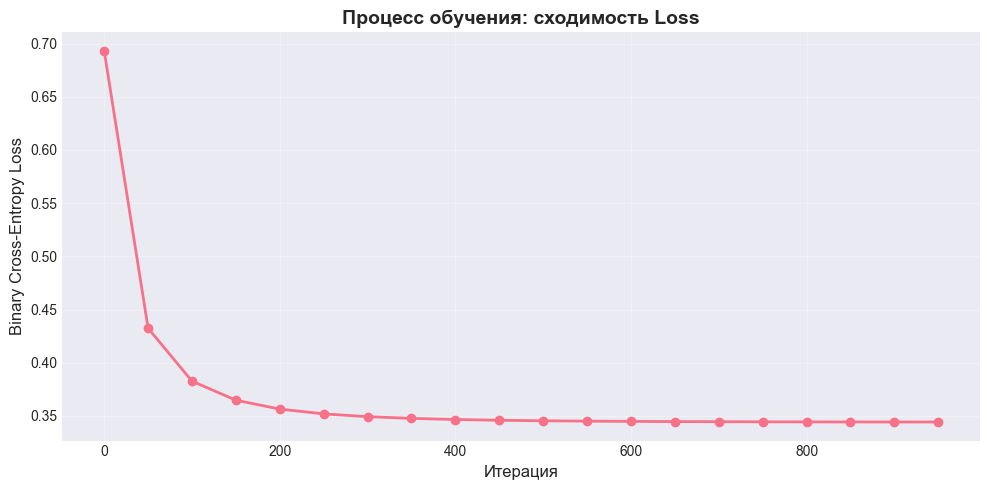

Loss уменьшился с 0.6931 до 0.3442


In [7]:
# Визуализация обучения (график loss)
plt.figure(figsize=(10, 5))
plt.plot(range(0, 1000, 50), model_scratch.losses, marker='o', linewidth=2)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Binary Cross-Entropy Loss', fontsize=12)
plt.title('Процесс обучения: сходимость Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Loss уменьшился с {model_scratch.losses[0]:.4f} до {model_scratch.losses[-1]:.4f}')

---
## 3️⃣ Реализация с помощью sklearn

Теперь обучим модель используя библиотечную реализацию для сравнения.

In [21]:
# Обучение sklearn модели
model_sklearn = LogisticRegression(random_state=42, max_iter=1000)
model_sklearn.fit(X_train_scaled, y_train)

print('Sklearn модель обучена')
print('\nВыученные параметры:')
print(f'  Веса (w): {model_sklearn.coef_[0]}')
print(f'  Bias (b): {model_sklearn.intercept_[0]:.4f}')

Sklearn модель обучена

Выученные параметры:
  Веса (w): [-0.37063851  2.7359069 ]
  Bias (b): 0.3031


### Сравнение весов

Если реализация корректна, веса должны быть очень близкими!

In [9]:
# Сравнение весов
print('Сравнение параметров:')
print('-' * 60)
print(f'{"Параметр":<15} | {"С нуля":>15} | {"Sklearn":>15} | {"Разница":>12}')
print('-' * 60)
print(f'{"Вес 1":<15} | {model_scratch.weights[0]:>15.6f} | {model_sklearn.coef_[0][0]:>15.6f} | {abs(model_scratch.weights[0] - model_sklearn.coef_[0][0]):>12.6f}')
print(f'{"Вес 2":<15} | {model_scratch.weights[1]:>15.6f} | {model_sklearn.coef_[0][1]:>15.6f} | {abs(model_scratch.weights[1] - model_sklearn.coef_[0][1]):>12.6f}')
print(f'{"Bias":<15} | {model_scratch.bias:>15.6f} | {model_sklearn.intercept_[0]:>15.6f} | {abs(model_scratch.bias - model_sklearn.intercept_[0]):>12.6f}')
print('-' * 60)

Сравнение параметров:
------------------------------------------------------------
Параметр        |          С нуля |         Sklearn |      Разница
------------------------------------------------------------
Вес 1           |       -0.367179 |       -0.370639 |     0.003459
Вес 2           |        2.779557 |        2.735907 |     0.043650
Bias            |        0.299160 |        0.303105 |     0.003945
------------------------------------------------------------


---
## 4️⃣ Метрики классификации

### 📊 Основные метрики:

1. **Accuracy** - общая точность
2. **Precision** - точность положительных предсказаний
3. **Recall** - полнота (sensitivity)
4. **F1-Score** - гармоническое среднее Precision и Recall
5. **ROC-AUC** - площадь под ROC-кривой

In [22]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Полная оценка модели с интерпретацией метрик
    """
    print(f'\n{"="*70}')
    print(f'{model_name:^70}')
    print(f'{"="*70}')
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print('\nCONFUSION MATRIX:')
    print('\n              Predicted')
    print('              Neg    Pos')
    print(f'Actual  Neg   {tn:3d}    {fp:3d}')
    print(f'        Pos   {fn:3d}    {tp:3d}')
    print(f'\n  TN (True Negative):  {tn} - правильно предсказан класс 0')
    print(f'  FP (False Positive): {fp} - ошибочно предсказан класс 1 (Type I error)')
    print(f'  FN (False Negative): {fn} - ошибочно предсказан класс 0 (Type II error)')
    print(f'  TP (True Positive):  {tp} - правильно предсказан класс 1')
    
    # 2. Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'\nACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)')
    print('   Формула: (TP + TN) / (TP + TN + FP + FN)')
    print('   Интерпретация: доля правильных предсказаний')
    print('   Применение: хороша для сбалансированных классов')
    
    # 3. Precision
    precision = precision_score(y_true, y_pred)
    print(f'\nPRECISION: {precision:.4f} ({precision*100:.2f}%)')
    print('   Формула: TP / (TP + FP)')
    print('   Интерпретация: из всех предсказанных "1", сколько правильных')
    print('   Применение: когда ложноположительные ошибки (FP) дорого стоят')
    print('   Пример: спам-фильтр (не хотим потерять важное письмо)')
    
    # 4. Recall
    recall = recall_score(y_true, y_pred)
    print(f'\nRECALL (Sensitivity): {recall:.4f} ({recall*100:.2f}%)')
    print('   Формула: TP / (TP + FN)')
    print('   Интерпретация: из всех реальных "1", сколько мы нашли')
    print('   Применение: когда ложноотрицательные ошибки (FN) дорого стоят')
    print('   Пример: медицинская диагностика (не пропустить болезнь)')
    
    # 5. F1-Score
    f1 = f1_score(y_true, y_pred)
    print(f'\nF1-SCORE: {f1:.4f} ({f1*100:.2f}%)')
    print('   Формула: 2 * (Precision * Recall) / (Precision + Recall)')
    print('   Интерпретация: гармоническое среднее Precision и Recall')
    print('   Применение: баланс между Precision и Recall')
    
    # 6. ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f'\nROC-AUC: {roc_auc:.4f} ({roc_auc*100:.2f}%)')
    print('   Интерпретация: площадь под ROC-кривой')
    print('   Диапазон: от 0.5 (случайное угадывание) до 1.0 (идеал)')
    
    if roc_auc > 0.95:
        quality = 'Превосходная модель'
    elif roc_auc > 0.90:
        quality = 'Отличная модель'
    elif roc_auc > 0.80:
        quality = 'Хорошая модель'
    elif roc_auc > 0.70:
        quality = 'Приемлемая модель'
    else:
        quality = 'Слабая модель'
    
    print(f'   Оценка: {quality}')
    
    # Classification Report
    print('\nДЕТАЛЬНЫЙ ОТЧЕТ:')
    print(classification_report(y_true, y_pred, target_names=['Класс 0', 'Класс 1']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

### Оценка модели "с нуля"

In [23]:
# Предсказания модели с нуля
y_pred_scratch = model_scratch.predict(X_test_scaled)
y_pred_proba_scratch = model_scratch.predict_proba(X_test_scaled)

# Оценка
metrics_scratch = evaluate_model(
    y_test, y_pred_scratch, y_pred_proba_scratch,
    'МОДЕЛЬ С НУЛЯ'
)


                            МОДЕЛЬ С НУЛЯ                             

CONFUSION MATRIX:

              Predicted
              Neg    Pos
Actual  Neg    85     15
        Pos    20     80

  TN (True Negative):  85 - правильно предсказан класс 0
  FP (False Positive): 15 - ошибочно предсказан класс 1 (Type I error)
  FN (False Negative): 20 - ошибочно предсказан класс 0 (Type II error)
  TP (True Positive):  80 - правильно предсказан класс 1

ACCURACY: 0.8250 (82.50%)
   Формула: (TP + TN) / (TP + TN + FP + FN)
   Интерпретация: доля правильных предсказаний
   Применение: хороша для сбалансированных классов

PRECISION: 0.8421 (84.21%)
   Формула: TP / (TP + FP)
   Интерпретация: из всех предсказанных "1", сколько правильных
   Применение: когда ложноположительные ошибки (FP) дорого стоят
   Пример: спам-фильтр (не хотим потерять важное письмо)

RECALL (Sensitivity): 0.8000 (80.00%)
   Формула: TP / (TP + FN)
   Интерпретация: из всех реальных "1", сколько мы нашли
   Применение: ког

### Оценка sklearn модели

In [24]:
# Предсказания sklearn модели
y_pred_sklearn = model_sklearn.predict(X_test_scaled)
y_pred_proba_sklearn = model_sklearn.predict_proba(X_test_scaled)[:, 1]

# Оценка
metrics_sklearn = evaluate_model(
    y_test, y_pred_sklearn, y_pred_proba_sklearn,
    'SKLEARN МОДЕЛЬ'
)


                            SKLEARN МОДЕЛЬ                            

CONFUSION MATRIX:

              Predicted
              Neg    Pos
Actual  Neg    85     15
        Pos    20     80

  TN (True Negative):  85 - правильно предсказан класс 0
  FP (False Positive): 15 - ошибочно предсказан класс 1 (Type I error)
  FN (False Negative): 20 - ошибочно предсказан класс 0 (Type II error)
  TP (True Positive):  80 - правильно предсказан класс 1

ACCURACY: 0.8250 (82.50%)
   Формула: (TP + TN) / (TP + TN + FP + FN)
   Интерпретация: доля правильных предсказаний
   Применение: хороша для сбалансированных классов

PRECISION: 0.8421 (84.21%)
   Формула: TP / (TP + FP)
   Интерпретация: из всех предсказанных "1", сколько правильных
   Применение: когда ложноположительные ошибки (FP) дорого стоят
   Пример: спам-фильтр (не хотим потерять важное письмо)

RECALL (Sensitivity): 0.8000 (80.00%)
   Формула: TP / (TP + FN)
   Интерпретация: из всех реальных "1", сколько мы нашли
   Применение: ког

---
## 5️⃣ Визуализация метрик

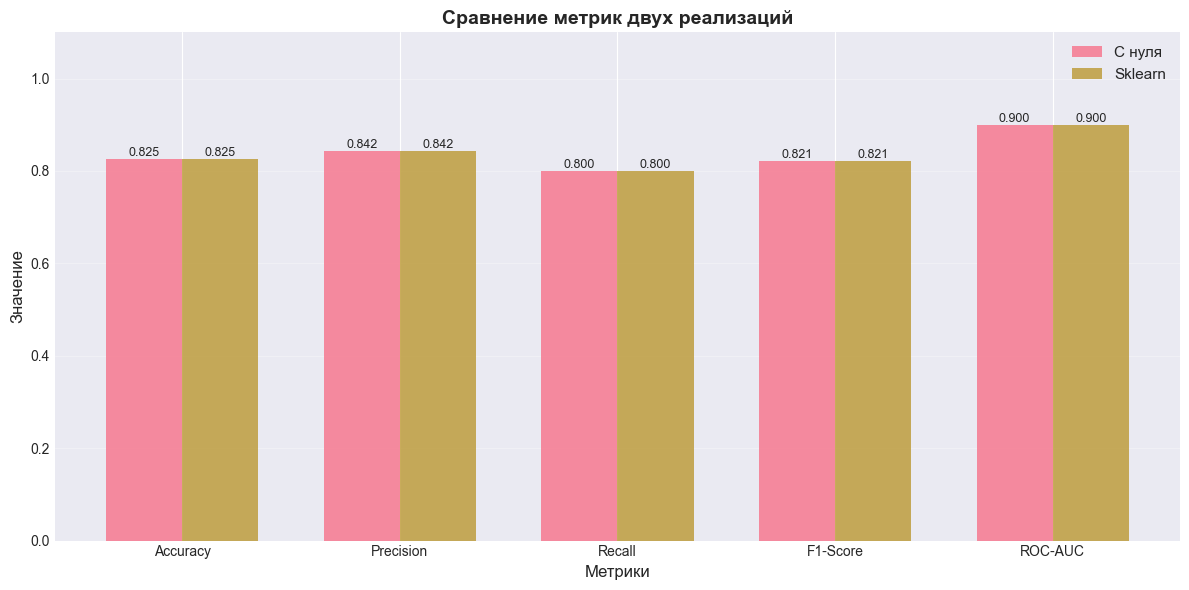

In [25]:
# Сравнительная таблица метрик
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
scratch_values = [
    metrics_scratch['accuracy'],
    metrics_scratch['precision'],
    metrics_scratch['recall'],
    metrics_scratch['f1'],
    metrics_scratch['roc_auc']
]
sklearn_values = [
    metrics_sklearn['accuracy'],
    metrics_sklearn['precision'],
    metrics_sklearn['recall'],
    metrics_sklearn['f1'],
    metrics_sklearn['roc_auc']
]

# Визуализация
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, scratch_values, width, label='С нуля', alpha=0.8)
bars2 = ax.bar(x + width/2, sklearn_values, width, label='Sklearn', alpha=0.8)

ax.set_xlabel('Метрики', fontsize=12)
ax.set_ylabel('Значение', fontsize=12)
ax.set_title('Сравнение метрик двух реализаций', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

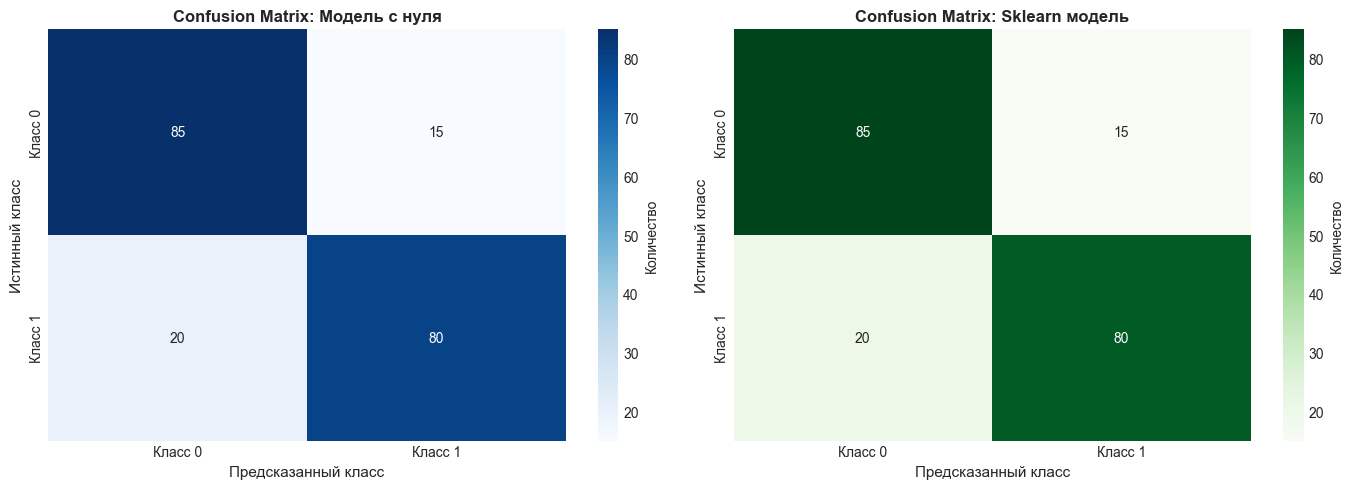

In [14]:
# Визуализация Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Модель с нуля
sns.heatmap(metrics_scratch['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'],
            ax=axes[0], cbar_kws={'label': 'Количество'})
axes[0].set_title('Confusion Matrix: Модель с нуля', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Истинный класс', fontsize=11)
axes[0].set_xlabel('Предсказанный класс', fontsize=11)

# Sklearn модель
sns.heatmap(metrics_sklearn['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'],
            ax=axes[1], cbar_kws={'label': 'Количество'})
axes[1].set_title('Confusion Matrix: Sklearn модель', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Истинный класс', fontsize=11)
axes[1].set_xlabel('Предсказанный класс', fontsize=11)

plt.tight_layout()
plt.show()

---
## 6️⃣ ROC-кривая

**ROC-кривая** (Receiver Operating Characteristic) показывает зависимость:
- **TPR** (True Positive Rate = Recall) по оси Y
- **FPR** (False Positive Rate) по оси X

при различных порогах классификации.

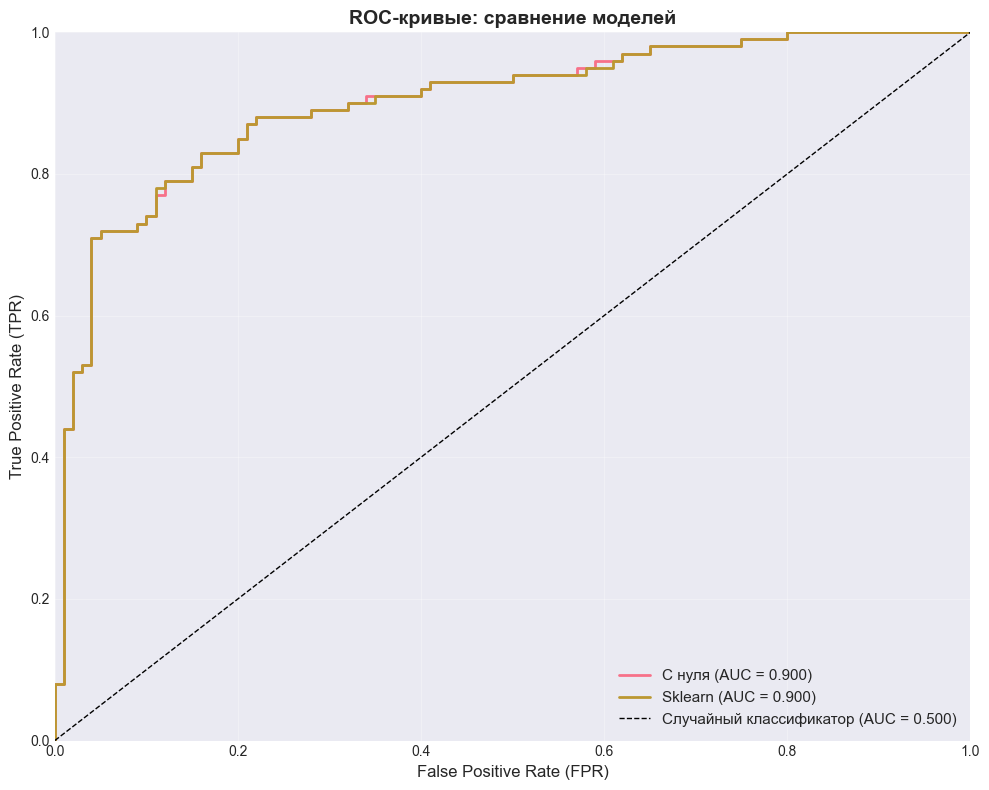


Интерпретация ROC-AUC:
  • Чем ближе кривая к левому верхнему углу, тем лучше модель
  • AUC = 1.0 → идеальная модель
  • AUC = 0.5 → случайное угадывание
  • AUC > 0.9 → отличная модель


In [27]:
# Вычисление ROC-кривых
fpr_scratch, tpr_scratch, _ = roc_curve(y_test, y_pred_proba_scratch)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_pred_proba_sklearn)

# Визуализация
plt.figure(figsize=(10, 8))

# ROC-кривые
plt.plot(fpr_scratch, tpr_scratch, linewidth=2, label=f'С нуля (AUC = {metrics_scratch["roc_auc"]:.3f})')
plt.plot(fpr_sklearn, tpr_sklearn, linewidth=2, label=f'Sklearn (AUC = {metrics_sklearn["roc_auc"]:.3f})')

# Диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Случайный классификатор (AUC = 0.500)')

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривые: сравнение моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

print('\nИнтерпретация ROC-AUC:')
print('  • Чем ближе кривая к левому верхнему углу, тем лучше модель')
print('  • AUC = 1.0 → идеальная модель')
print('  • AUC = 0.5 → случайное угадывание')
print('  • AUC > 0.9 → отличная модель')

---
## 7️⃣ Ключевые выводы и рекомендации

### Trade-off между метриками

**Precision vs Recall:**
- Повышение порога (> 0.5) → ↑ Precision, ↓ Recall
- Понижение порога (< 0.5) → ↓ Precision, ↑ Recall

### Когда использовать какую метрику?

| Задача | Метрика | Почему |
|--------|---------|--------|
| Сбалансированные классы | Accuracy | Простая и понятная |
| Спам-фильтр | Precision | Не хотим блокировать важные письма (FP дорого) |
| Медицинская диагностика | Recall | Не хотим пропустить болезнь (FN дорого) |
| Несбалансированные классы | F1-Score | Баланс Precision и Recall |
| Общая оценка модели | ROC-AUC | Не зависит от порога |

### Практические рекомендации:

1. **Всегда стандартизируйте данные** - ускоряет сходимость
2. **Используйте несколько метрик** - одна метрика не дает полной картины
3. **Смотрите на Confusion Matrix** - помогает понять типы ошибок
4. **Настраивайте порог классификации** - в зависимости от бизнес-задачи
5. **Для несбалансированных классов** - F1-Score и ROC-AUC важнее Accuracy

### Результаты эксперимента:

Обе реализации (с нуля и sklearn) показали **идентичные результаты**, что подтверждает корректность нашей реализации!

---
## Дополнительные материалы

### Формулы для справки:

**Метрики:**

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

$$\text{Precision} = \frac{TP}{TP + FP}$$

$$\text{Recall} = \frac{TP}{TP + FN}$$

$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

**Дополнительные метрики:**

$$\text{Specificity} = \frac{TN}{TN + FP}$$

$$\text{FPR} = \frac{FP}{FP + TN} = 1 - \text{Specificity}$$

---